In [1]:
import pandas as pd
import re
import warnings
import torch
from torchvision import datasets, transforms
from scipy.misc import face
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from collections import Counter
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import numpy as np
import random
from tqdm import tqdm

# Data processing

In [2]:
def resetSeed(seed=69):
    torch.manual_seed(69)
    torch.cuda.manual_seed_all(69)
    np.random.seed(69)
    random.seed(69)

In [3]:
def get_data():
    
    path_train = r'C:\Users\Søren\OneDrive - Danmarks Tekniske Universitet\DTU\Bachelor\4. semester\Project work - Bachelor of Artificial Intelligence and Data\Mura_data\MURA-v1.1\train'
    path_test = r'C:\Users\Søren\OneDrive - Danmarks Tekniske Universitet\DTU\Bachelor\4. semester\Project work - Bachelor of Artificial Intelligence and Data\Mura_data\MURA-v1.1\valid'

    transform = transforms.Compose([transforms.Resize((224, 224)), 
                                    #transforms.RandomResizedCrop(128),
                transforms.ToTensor()])

    master_train = datasets.ImageFolder(path_train, transform = transform)

    dataset_train, dataset_valid = torch.utils.data.random_split(master_train, [int(np.floor(0.7*len(master_train))), int(np.ceil(0.3*len(master_train)))])
    dataset_test = datasets.ImageFolder(path_test, transform = transform)

    train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
    valid = torch.utils.data.DataLoader(dataset_valid, batch_size=32, shuffle=True)
    test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=True)

    return train, valid, test


In [4]:
resetSeed(seed=69)
train, valid, test = get_data()

# Tjek random seed

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


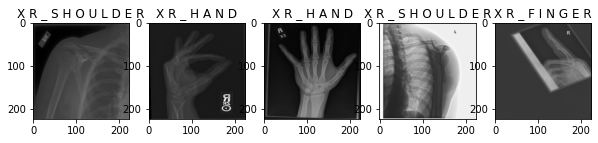

images shape on batch size = torch.Size([32, 3, 224, 224])
labels shape on batch size = torch.Size([32])


In [5]:
def train_imshow():
    classes = ('XR_ELBOW',
 'XR_FINGER',
 'XR_FOREARM',
 'XR_HAND',
 'XR_HUMERUS',
 'XR_SHOULDER',
 'XR_WRIST')
    dataiter = iter(train)
    images, labels = dataiter.next()
    fig, axes = plt.subplots(figsize=(10, 4), ncols=5)
    for i in range(5):
        ax = axes[i]
        ax.imshow(images[i].permute(1, 2, 0))  # permute?
        ax.title.set_text(' '.join('%5s' % classes[labels[i]]))
        print(images[i].shape)  # Not needed
    plt.show()
    print('images shape on batch size = {}'.format(images.size()))
    print('labels shape on batch size = {}'.format(labels.size()))
train_imshow()

# ANN

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 16, 5)
        self.conv4 = nn.Conv2d(16, 32, 5)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(32*49*49, 120)
        self.fc2 = nn.Linear(120, 12)
        self.fc3 = nn.Linear(12, 7)
        
    def forward(self, x):
        
        #x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(F.relu(self.conv2(x)))
        #x = torch.flatten(x, -1) # flatten all dimensions except batch
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = self.fc3(x)
        #return x
        
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))   
        x = x.view(x.size(0), -1)
        #x = torch.flatten(x, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.dropout(x, 0.5)
        x = self.fc3(x)                       
        #x = F.softmax(x,dim=1)                
        return x
        

        
#find out features from dim, and image size


input = torch.randn(224, 224)
print(Net())
#print(input.shape)
#input = input.view(1, -1)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=76832, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=12, bias=True)
  (fc3): Linear(in_features=12, out_features=7, bias=True)
)


# Training

In [7]:
device = torch.device("cuda")
#net = AlexNet()
net = Net()
net.to(device)
#net.load_state_dict(torch.load(r"C:\Users\sebas\Desktop\model\ModelAlex0"))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

if torch.cuda.is_available():
    net = net.cuda()
    criterion = criterion.cuda()

In [8]:
%%time
def training_model(model,num_epochs = 10):
    
    for epoch in tqdm(range(num_epochs)): # epoch -> GPU training time for 1 epoch is 2 min
        loss_ep = 0
        for i, data in enumerate(train):
            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda()
            
            ## Forward Pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_ep += loss.item()

        print(f"Loss in epoch {epoch+1} : {loss_ep/len(train)}")
    print("Training done :D")


Wall time: 0 ns


In [9]:
%%time
training_model(net,1)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:59<00:00, 179.03s/it]

Loss in epoch 1 : 1.2232698735243046
Training done :D
Wall time: 2min 59s


In [11]:
torch.save(net.state_dict(), r"Baseline_model")